# Step #1 Load the Data

In [240]:
# A tutorial for this file is available at www.relataly.com
# Tested with Python 3.8.8, Matplotlib 3.5, Scikit-learn 0.24.1, Seaborn 0.11.1, numpy 1.19.5

from codecs import ignore_errors
import math
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})
from pandas.api.types import is_string_dtype, is_numeric_dtype 
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.inspection import permutation_importance

# Data Source: 
# https://www.kaggle.com/datasets/lepchenkov/usedcarscatalog

# Load train and test datasets
path = 'C:/Users/Flo7u/workspace/relataly-public-python-tutorials/data/new_data.csv' #"https://raw.githubusercontent.com/flo7up/relataly_data/main/car_prices/train.csv"
df = pd.read_csv(path) #, low_memory=False, error_bad_lines=False

df.head(3)

,prod_year,maker,model,trim,body_type,transmission_type,state,condition,odometer,exterior_color,interior,sellingprice,date
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,21500,2014-12-16
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,21500,2014-12-16
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,4.5,1331.0,gray,black,30000,2015-01-15


In [241]:
# for i in range(len(df['date'])):
#     try:
#         df['date'].iloc[i]=df['date'][i].date() 
#     except:
#         print('error')
# df.drop(columns=['seller'], inplace=True)
# df.to_csv('C:/Users/Flo7u/workspace/relataly-public-python-tutorials/data/new_data.csv',index=False)
# df.sort_values(by='date', ascending=True)

# Step #2 Data Cleansing

In [242]:
# rename some columns
df.rename(columns={'exterior_color': 'ext_color', 'interior': 'int_color', 'sellingprice': 'sale_price'}, inplace=True)

In [243]:
# check and remove dublicates
print(len(df))
df = df.drop_duplicates()
print(len(df))

558811
558811


Text(0.5, 1.0, 'Overview of missing values')

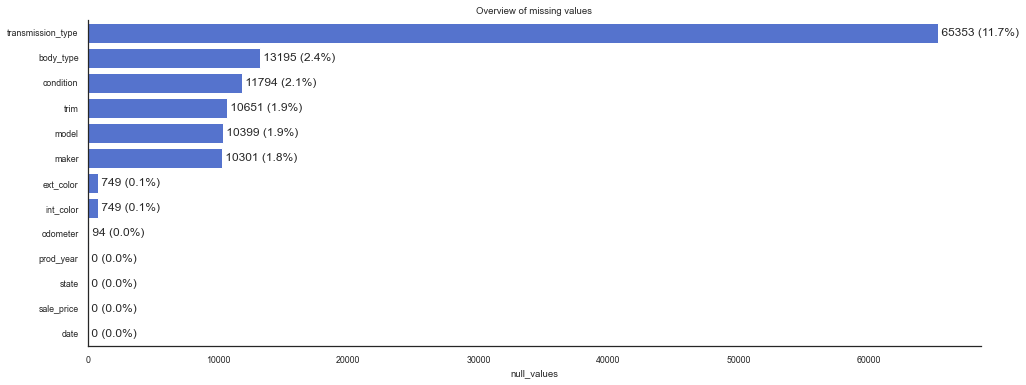

In [244]:
# check for missing values
null_df = pd.DataFrame(df.isna().sum(), columns=['null_values']).sort_values(['null_values'], ascending=False)
fig = plt.subplots(figsize=(16, 6))
ax = sns.barplot(data=null_df, x='null_values', y=null_df.index, color='royalblue')
pct_values = [' {:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(null_df['null_values'])]
ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)
ax.set_title('Overview of missing values')

In [245]:
# fill missing values with the mean for numeric columns
for col_name in df.columns:
    if (is_numeric_dtype(df[col_name])) and (df[col_name].isna().sum() > 0):
        df[col_name].fillna(df[col_name].median(), inplace=True) # alternatively you could also drop the columns with missing values using .drop(columns=['engine_capacity']) 

print(df.isna().sum())

prod_year                0
maker                10301
model                10399
trim                 10651
body_type            13195
transmission_type    65353
state                    0
condition                0
odometer                 0
ext_color              749
int_color              749
sale_price               0
date                     0
dtype: int64


In [246]:
# check the distribution of missing values for transmission type
print(df['transmission_type'].value_counts())

# fill values with the dominant value (automatic)
df['transmission_type'].fillna("automatic", inplace=True)
print(df['transmission_type'].isna().sum())




automatic    475914
manual        17544
Name: transmission_type, dtype: int64
0


In [247]:
# check the distribution of missing values for body type
print(df['body_type'].value_counts())

# fill values with the dominant value (Sedan)
df['body_type'].fillna("Sedan", inplace=True)
print(df['body_type'].isna().sum())


Sedan          199437
SUV            119292
sedan           41906
suv             24552
Hatchback       21380
                ...  
g37 coupe           1
cab plus 4          1
CTS-V Wagon         1
Ram Van             1
cts wagon           1
Name: body_type, Length: 86, dtype: int64
0


In [248]:
# remove all other records with missing values
df.dropna(inplace=True)

In [249]:
# Create a copy of the dataset with all features for comparison reasons
df_all = df.copy()

# Step #3 Univariate Analysis

In [250]:
# consistently define the target variable
target_name = 'sale_price'

In [251]:
# Statistics for numeric values
print(df.columns)
df.describe()

Index(['prod_year', 'maker', 'model', 'trim', 'body_type', 'transmission_type',
       'state', 'condition', 'odometer', 'ext_color', 'int_color',
       'sale_price', 'date'],
      dtype='object')


,prod_year,condition,odometer,sale_price
count,547333.000000,547333.000000,547333.000000,547333.000000
mean,2010.116359,3.437117,67537.877212,13682.172221
std,3.905699,0.936624,52871.683581,9680.959148
min,1989.000000,1.000000,1.000000,1.000000
25%,2008.000000,2.700000,28156.000000,7000.000000
50%,2012.000000,3.600000,51423.000000,12200.000000
75%,2013.000000,4.200000,97920.000000,18300.000000
max,2015.000000,5.000000,999999.000000,230000.000000


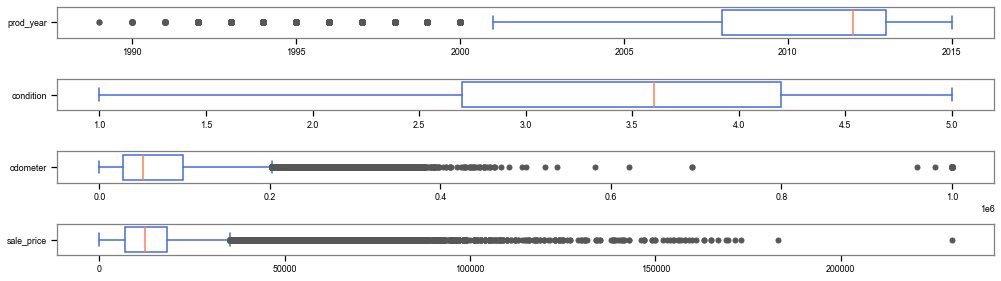

In [252]:
# 3.2 Illustrate the Variance of Numeric Variables 
f_list_numeric = [x for x in df.columns if (is_numeric_dtype(df[x]) and df[x].nunique() > 2)]
f_list_numeric

# box plot design
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'royalblue'},
    'medianprops':{'color':'coral'},
    'whiskerprops':{'color':'royalblue'},
    'capprops':{'color':'royalblue'}
    }
sns.set_style('ticks', {'axes.edgecolor': 'grey',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

# Adjust plotsize based on the number of features
ncols = 1
nrows = math.ceil(len(f_list_numeric) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(14, nrows*1))
for i, ax in enumerate(fig.axes):
    if i < len(f_list_numeric):
        column_name = f_list_numeric[i]
        sns.boxplot(data=df[column_name], orient="h", ax = ax, color='royalblue', flierprops={"marker": "o"}, **PROPS)
        ax.set(yticklabels=[column_name])
        fig.tight_layout()

In [253]:
# remove outliers
df = df[df['sale_price'] <= 150000]

categorical features: 3


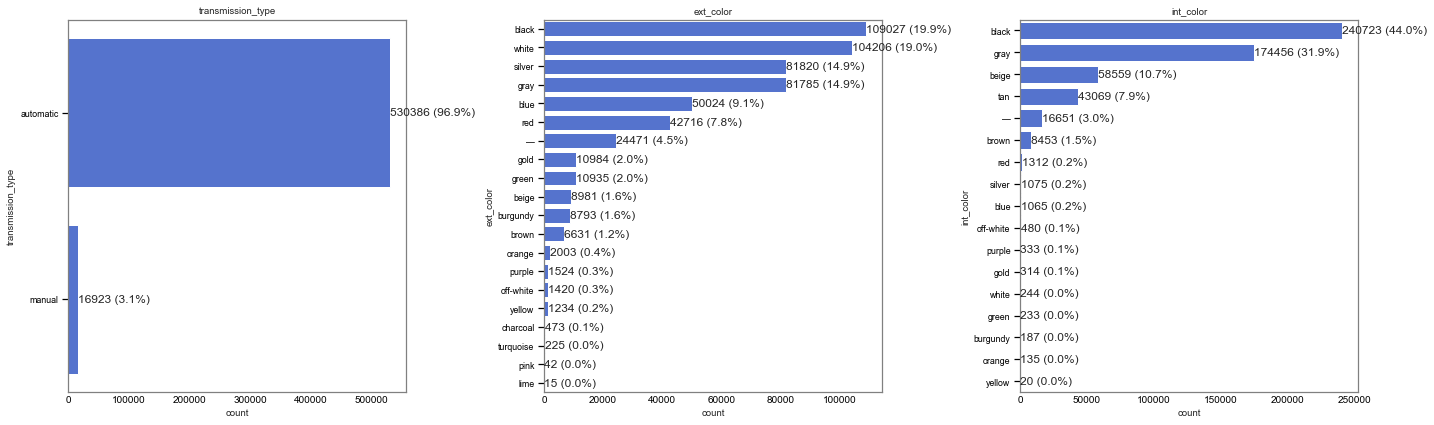

In [254]:
# 3.2 Visualize the Variance of Categorical Variables

# Barplots to visualize the distribution of categorical variables
f_list = [x for x in df.columns if is_string_dtype(df[x]) and df[x].nunique() < 21]
f_list_len = len(f_list)
print(f'categorical features: {f_list_len}')

# Adjust plotsize based on the number of features
ncols = 3
nrows = math.ceil(f_list_len / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows*6))
for i, ax in enumerate(fig.axes):
    if i < f_list_len:
        column_name = f_list[i]
        sns.countplot(data=df, y=column_name, ax=ax, color='royalblue', order = df[column_name].value_counts().index)
        pct_values = ['{:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(df[column_name].value_counts())]
        ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)
        ax.tick_params(axis="x", rotation=0, labelsize=10, length=0)
        ax.set_title(column_name)
        fig.tight_layout() 

In [255]:
# Drop features with low variety
df = df.drop(columns=['transmission_type'])
df.head(2)

,prod_year,maker,model,trim,body_type,state,condition,odometer,ext_color,int_color,sale_price,date
0,2015,Kia,Sorento,LX,SUV,ca,5.0,16639.0,white,black,21500,2014-12-16
1,2015,Kia,Sorento,LX,SUV,ca,5.0,9393.0,white,beige,21500,2014-12-16


In [256]:
# Binning features
df['int_color'] = [x if  x in(['black', 'gray', 'white', 'silver', 'blue', 'red']) else 'other' for x in df['int_color']]
df['ext_color'] = [x if  x in(['black', 'gray', 'white', 'silver', 'blue', 'red']) else 'other' for x in df['ext_color']]

(0.0, 44500.0)

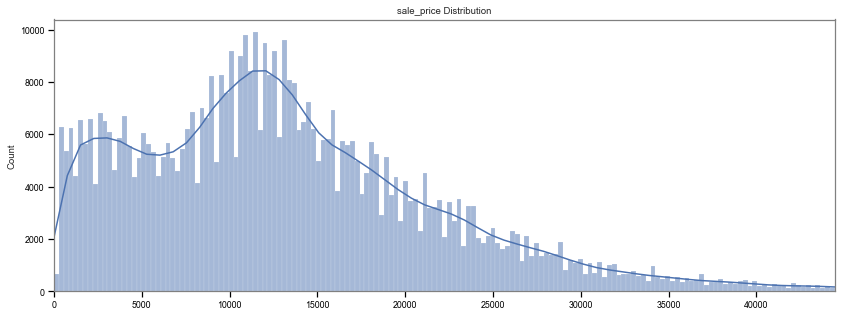

In [257]:
# Explore the distrution of the target variable
variable_name = 'sale_price'
fig, ax = plt.subplots(figsize=(14,5))
sns.histplot(data=df[[variable_name]].dropna(), ax=ax, color='royalblue', kde=True)
ax.get_legend().remove()
ax.set_title(variable_name + ' Distribution')
ax.set_xlim(0, df[variable_name].quantile(0.99))

# Step #3 Bivariate Analysis

In [258]:
df['state']

0         ca
1         ca
2         ca
3         ca
4         ca
          ..
558806    in
558807    wa
558808    ca
558809    ga
558810    ca
Name: state, Length: 547309, dtype: object

In [259]:
#is_numeric_dtype(df['state'])

numeric features: 6
prod_year
state
condition
odometer
ext_color
int_color


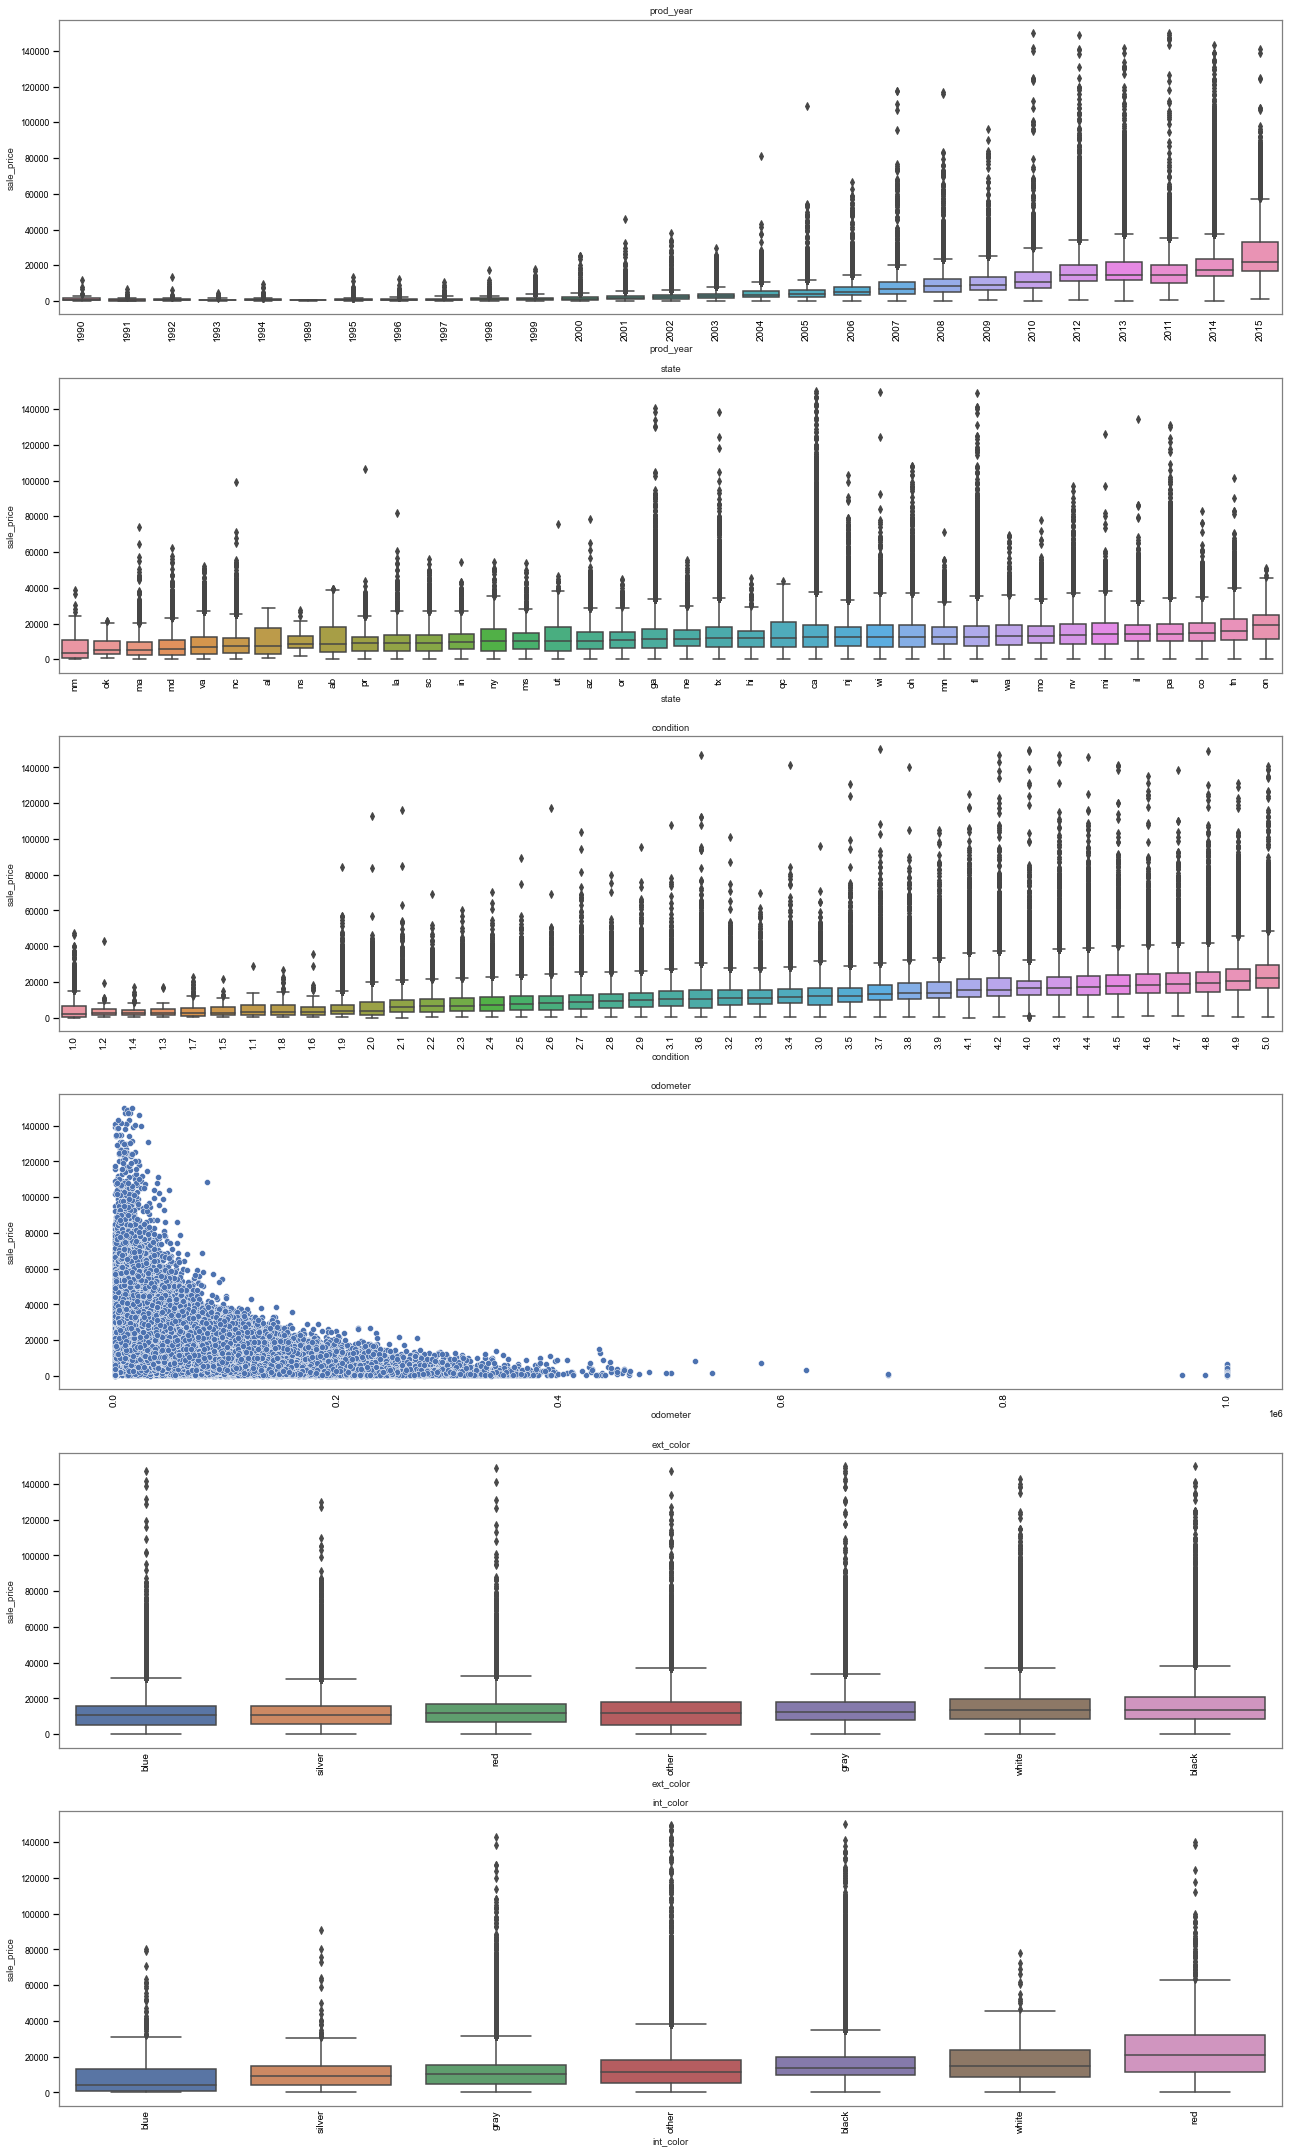

In [260]:
# Vizualising Distributions
f_list = [x for x in df.columns if ((is_numeric_dtype(df[x])) and x != target_name) or (df[x].nunique() < 50)]
f_list_len = len(f_list)
print(f'numeric features: {f_list_len}')

# Adjust plotsize based on the number of features
ncols = 1
nrows = math.ceil(f_list_len / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(18, nrows*5))
for i, ax in enumerate(fig.axes):
    if i < f_list_len:
        column_name = f_list[i]
        print(column_name)
        # If a variable has more than 8 unique values draw a scatterplot, else draw a violinplot 
        if df[column_name].nunique() > 100 and is_numeric_dtype(df[column_name]):
            # Draw a scatterplot for each variable and target_name
            sns.scatterplot(data=df, y=target_name, x=column_name, ax = ax)
        else: 
            # Draw a vertical violinplot (or boxplot) grouped by a categorical variable:
            myorder = df.groupby(by=[column_name])[target_name].median().sort_values().index
            sns.boxplot(data=df, x=column_name, y=target_name, ax = ax, order=myorder)
            #sns.violinplot(data=df, x=column_name, y=target_name, ax = ax, order=myorder)
        ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)
        ax.set_title(column_name)
    fig.tight_layout()

In [261]:
df.drop(columns=['state', 'ext_color', 'int_color'], inplace=True)

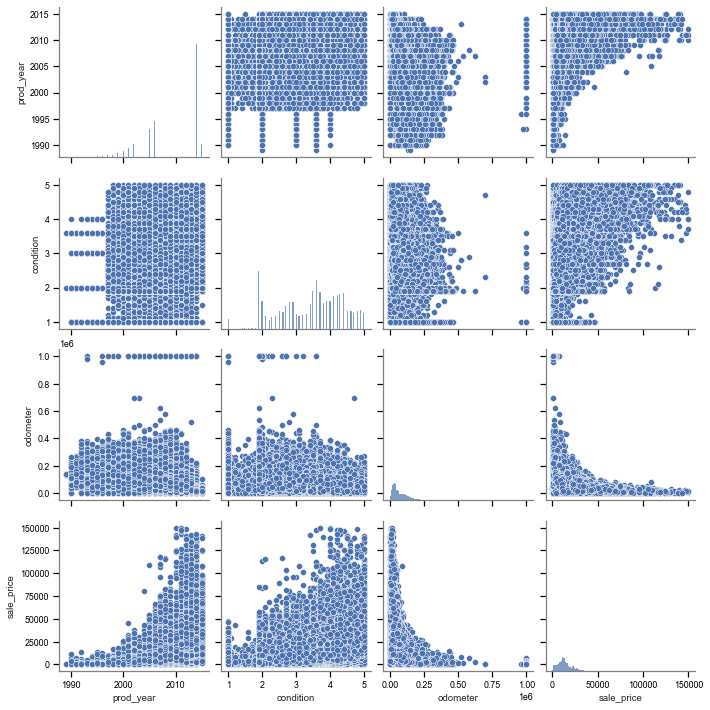

In [262]:
sns.pairplot(df)

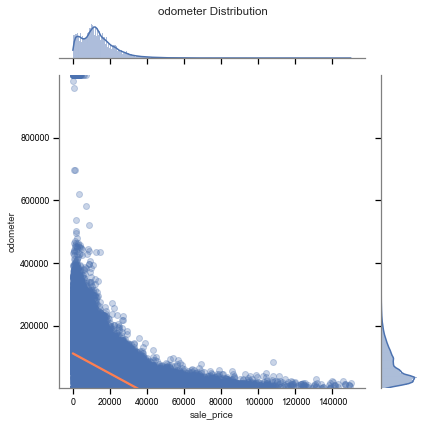

In [263]:
# Explore the distrution of specific variables
feature_name = 'odometer'

p = sns.jointplot(data=df, y=feature_name, x=target_name, height=6, ratio=6, kind='reg', joint_kws={'line_kws':{'color':'coral'}})
# Alternatively you can use hex_binning
# p = sns.jointplot(data=df, y=feature_name, x=target_name, height=10, ratio=6, kind="hex")

p.fig.suptitle(feature_name + ' Distribution')
p.ax_joint.collections[0].set_alpha(0.3)
p.ax_joint.set_ylim(df[feature_name].min(), df[feature_name].max())
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

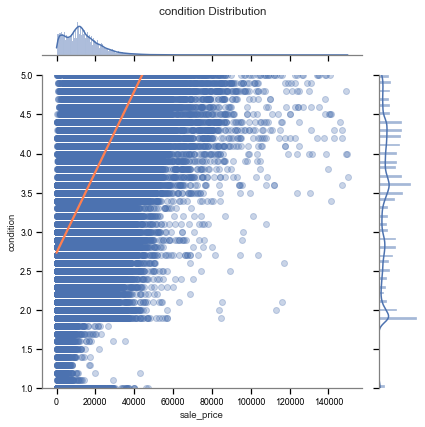

In [264]:
# Explore the distrution of specific variables
feature_name = 'condition'

p = sns.jointplot(data=df, y=feature_name, x=target_name, height=6, ratio=6, kind='reg', joint_kws={'line_kws':{'color':'coral'}})
# Alternatively you can use hex_binning
# p = sns.jointplot(data=df, y=feature_name, x=target_name, height=10, ratio=6, kind="hex")
p.fig.suptitle(feature_name + ' Distribution')
p.ax_joint.collections[0].set_alpha(0.3)
p.ax_joint.set_ylim(df[feature_name].min(), df[feature_name].max())
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

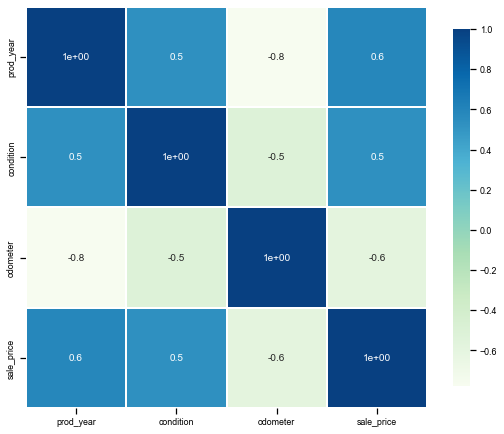

In [265]:
# correlation heatmap allows us to identify highly correlated explanatory variables and reduce collinearity
plt.figure(figsize = (9,8))
plt.yticks(rotation=0)
correlation = df.corr()
ax =  sns.heatmap(correlation, cmap='GnBu',square=True, linewidths=.1, cbar_kws={"shrink": .82},annot=True,
            fmt='.1',annot_kws={"size":10})
sns.set(font_scale=0.8)
for f in ax.texts:
        f.set_text(f.get_text())  

In [266]:
# we remove the variables that are the least correlated with the target variable
# df.drop(columns=['int_color', 'ext_color'], inplace=True)

# Step #5 Preprocessing

In [267]:
# encode categorical variables 
def encode_categorical_variables(df):
    # create a list of categorical variables that we want to encode
    categorical_list = [x for x in df.columns if is_string_dtype(df[x])]
    le = LabelEncoder()
    # apply the encoding to the categorical variables
    # because the apply() function has no inplace argument,  we use the following syntax to transform the df
    df[categorical_list] = df[categorical_list].apply(LabelEncoder().fit_transform)
    return df

df_final_subset = encode_categorical_variables(df)
df_all_ = encode_categorical_variables(df_all)

# create a copy of the dataframe but without the target variable
df_without_target = df.drop(columns=[target_name])
df_final_subset.head()

,prod_year,maker,model,trim,body_type,condition,odometer,sale_price,date
0,2015,24,650,1003,35,5.0,16639.0,21500,12
1,2015,24,650,1003,35,5.0,9393.0,21500,12
2,2014,3,9,287,36,4.5,1331.0,30000,34
3,2015,51,589,1407,36,4.1,14282.0,27750,44
4,2014,3,36,503,36,4.3,2641.0,67000,14


# Step #6 Splitting the Data and Training the Model

In [272]:
def splitting(df, name):
    # separate labels from training data
    X = df.drop(columns=[target_name])
    y = df[target_name] #Prediction label

    # split the data into x_train and y_train data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print(name + '')
    print('train: ' + X_train.shape, y_train.shape)
    print('test: ' + X_test.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

# train the model
def train_model(X, y, X_train, y_train):
    estimator = DecisionTreeRegressor() 
    scores = cross_val_score(estimator, X, y, cv=5)
    estimator.fit(X_train, y_train)
    return scores, estimator

# train the model with the subset of selected features
X_sub, y_sub, X_train_sub, X_test_sub, y_train_sub, y_test_sub = splitting(df_final_subset, 'subset')
scores_sub, estimator_sub = train_model(X_sub, y_sub, X_train_sub, y_train_sub)
    
# train the model with all features
X_all, y_all, X_train_all, X_test_all, y_train_all, y_test_all = splitting(df_all_, 'allset')
scores_all, estimator_all = train_model(X_all, y_all, X_train_all, y_train_all)

subset: train and test shapes
(383116, 8) (383116,)
(164193, 8) (164193,)
allset: train and test shapes
(383133, 12) (383133,)
(164200, 12) (164200,)


# Step #7 Model Comparison - Subset vs Allsett

Mean Absolute Error (MAE): 1720.13
Mean Absolute Percentage Error (MAPE): 23.29 %
Mean Absolute Error (MAE): 1784.57
Mean Absolute Percentage Error (MAPE): 37.41 %


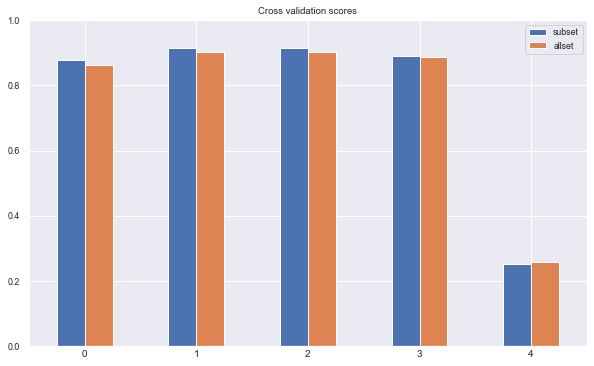

In [270]:
def create_metrics(scores, estimator, X_test, y_test, col_name):
    scores_df = pd.DataFrame({col_name:scores})

    # predict on the test set
    y_pred = estimator.predict(X_test)
    y_df = pd.DataFrame(y_test)
    y_df['PredictedPrice']=y_pred

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test, y_pred)
    print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

    # Mean Absolute Percentage Error (MAPE)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE*100, 2)) + ' %')
    
    # calculate the feature importance scores
    r = permutation_importance(estimator, X_test, y_test, n_repeats=30, random_state=0)
    data_im = pd.DataFrame(r.importances_mean, columns=['feature_permuation_score'])
    data_im['feature_names'] = X_test.columns
    data_im = data_im.sort_values('feature_permuation_score', ascending=False)
    
    return scores_df, data_im

scores_df_sub, data_im_sub = create_metrics(scores_sub, estimator_sub, X_test_sub, y_test_sub, 'subset')
scores_df_all, data_im_all = create_metrics(scores_all, estimator_all, X_test_all, y_test_all, 'allset')
scores_df = pd.concat([scores_df_sub, scores_df_all],  axis=1)

# visualize how the two models have performed in each fold
fig, ax = plt.subplots(figsize=(10, 6))
scores_df.plot(y=["subset", "allset"], kind="bar", ax=ax)
ax.set_title('Cross validation scores')
ax.set(ylim=(0, 1))
ax.tick_params(axis="x", rotation=0, labelsize=10, length=0)

In [273]:
# compare the feature importance scores of the subset model to the fullset model
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(data=data_im_sub, y='feature_names', x="feature_permuation_score", ax=axs[0])
axs[0].set_title("Feature importance scores of the subset model")
sns.barplot(data=data_im_all, y='feature_names', x="feature_permuation_score", ax=axs[1])
axs[1].set_title("Feature importance scores of the fullset model")

Text(0.5, 1.0, 'Feature importance scores of the fullset model')